In [1]:
import os
import csv
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
BASE_DIR = "D:/mysql-2019-06-01/"

## How many repos are there?

In [2]:
cnt = 0
start = time.time()
input_file = open(os.path.join(BASE_DIR, "projects.csv"), newline='', encoding="utf8")
csvreader = csv.reader(input_file, delimiter=',', quotechar='"', escapechar='\\')
while True:
    try:
        t = csvreader.__next__()
        assert len(t) == 11
        cnt += 1
    except StopIteration:
        print("finish reading")
        break
input_file.close()
end = time.time()
print(end - start)
print(cnt)

finish reading
902.3962996006012
125486232


In [3]:
cnt = 0
start = time.time()
input_file = open(os.path.join(BASE_DIR, "projects.csv"), newline='', encoding="utf8")
output_file = open('selected_projects.csv', 'w+', newline='', encoding="utf8")
csvreader = csv.reader(input_file, delimiter=',', quotechar='"', escapechar='\\')
csvwriter = csv.writer(output_file, delimiter=',', quotechar='"', escapechar='\\', quoting=csv.QUOTE_NONE)
while True:
    try:
        t = csvreader.__next__()
        assert len(t) == 11
        if t[7] == 'N':
            cnt += 1
            csvwriter.writerow(t)
    except StopIteration:
        print("finish reading")
        break
input_file.close()
output_file.close()
end = time.time()
print(end - start)
print(cnt)

finish reading
1723.4419524669647
77934458


## What labels are most commonly used?

In [4]:
issue_label = pd.read_csv(os.path.join(BASE_DIR, "issue_labels.csv"), names=['label_id', 'issue_id'])

In [5]:
valid_id = set(issue_label['label_id'])

In [6]:
start = time.time()
input_file = open(os.path.join(BASE_DIR, "repo_labels.csv"), newline='', encoding="utf8")
output_file = open('valid_repo_labels.csv', 'w+', newline='', encoding="utf8")
csvreader = csv.reader(input_file, delimiter=',', quotechar='"', escapechar='\\')
csvwriter = csv.writer(output_file, delimiter=',', quotechar='"', escapechar='\\', quoting=csv.QUOTE_NONE)
while True:
    try:
        t = csvreader.__next__()
        # assert len(t) == 3
        if int(t[0]) in valid_id:
            csvwriter.writerow(t)
        # print(t)
    except StopIteration:
        print("finish reading")
        break
input_file.close()
output_file.close()
end = time.time()
print(end - start)

finish reading
846.9476141929626


In [7]:
label_dict = {}
cnt = 0
start = time.time()
input_file = open('valid_repo_labels.csv', newline='', encoding="utf8")
csvreader = csv.reader(input_file, delimiter=',', quotechar='"', escapechar='\\')
# for _ in range(10):
while True:
    try:
        t = csvreader.__next__()
        assert len(t) == 3
        if t[2].lower() in label_dict:
            label_dict[t[2].lower()] += 1
        else:
            label_dict[t[2].lower()] = 1
        cnt += 1
    except StopIteration:
        print("finish reading")
        break
input_file.close()
end = time.time()
print(end - start)
print(cnt)

finish reading
9.947875022888184
3305505


In [8]:
sorted_dict = sorted(label_dict.items(), key=lambda x:x[1], reverse=True)

In [9]:
len(sorted_dict)

356515

In [10]:
sorted_dict[:20]

[('enhancement', 625682),
 ('bug', 520372),
 ('question', 154082),
 ('help wanted', 136957),
 ('wontfix', 73516),
 ('invalid', 50326),
 ('feature', 48557),
 ('duplicate', 45590),
 ('good first issue', 43437),
 ('in progress', 32692),
 ('documentation', 25121),
 ('ready', 17681),
 ('task', 15512),
 ('epic', 14416),
 ('todo', 13070),
 ('feature request', 11975),
 ('hacktoberfest', 10974),
 ('discussion', 9928),
 ('design', 8599),
 ('new feature', 7740)]

## What labels tend to be used together?

In [2]:
name_dict = {}
cnt = 0
start = time.time()
input_file = open('valid_repo_labels.csv', newline='', encoding="utf8")
csvreader = csv.reader(input_file, delimiter=',', quotechar='"', escapechar='\\')
while True:
    try:
        t = csvreader.__next__()
        assert len(t) == 3
        name_dict[int(t[0])] = t[2].lower()
        cnt += 1
    except StopIteration:
        print("finish reading")
        break
input_file.close()
end = time.time()
print(end - start)
print(cnt)

finish reading
5.68888521194458
3305505


In [3]:
issues = pd.read_csv(os.path.join(BASE_DIR, "issue_labels.csv"), names=['label_id', 'issue_id'])
issues = issues.sort_values('issue_id')

In [4]:
edge_dict = {}

def update_edge_dict(label_list):
    if len(label_list) > 1:
        for i in range(len(label_list) - 1):
            for j in range(i + 1, len(label_list)):
                name1, name2 = name_dict[label_list[i]], name_dict[label_list[j]]
                if name1 > name2:
                    name1, name2 = name2, name1
                dict_key = (name1, name2)
                if dict_key in edge_dict:
                    edge_dict[dict_key] += 1
                else:
                    edge_dict[dict_key] = 1

k = 0
cur_issue = None
label_list = []
pbar = tqdm(total=issues.shape[0])
while k < issues.shape[0]:
    if cur_issue is None or cur_issue != int(issues.iloc[k, 1]):
        update_edge_dict(label_list)
        cur_issue = int(issues.iloc[k, 1])
        label_list = [int(issues.iloc[k, 0])]
    else:
        label_list.append(int(issues.iloc[k, 0]))
    k += 1
    pbar.update(1)
update_edge_dict(label_list)
pbar.close()

100%|███████████████████████████████████████████████████████████████████| 27474913/27474913 [11:55<00:00, 38418.16it/s]


In [5]:
sorted_dict = sorted(edge_dict.items(), key=lambda x:x[1], reverse=True)
sorted_dict[:30]

[(('enhancement', 'help wanted'), 134694),
 (('bug', 'enhancement'), 111756),
 (('bug', 'help wanted'), 61986),
 (('enhancement', 'question'), 61244),
 (('agent_chrome', 'type_not-translated'), 58988),
 (('bug', 'fixed'), 56560),
 (('agent_chrome', 'agent_win7'), 51308),
 (('agent_chrome', 'lang_es'), 49085),
 (('bug', 'imported'), 48594),
 (('priority-medium', 'type-defect'), 45922),
 (('enhancement', 'wontfix'), 44846),
 (('auto-migrated', 'priority-medium'), 42368),
 (('agent_chrome', 'lang_pt'), 41489),
 (('auto-migrated', 'type-defect'), 39616),
 (('enhancement', 'good first issue'), 37992),
 (('agent_win7', 'type_not-translated'), 37784),
 (('imported', 'priority-medium'), 37593),
 (('lang_es', 'type_not-translated'), 36955),
 (('good first issue', 'help wanted'), 35063),
 (('bug', 'wontfix'), 34927),
 (('bug', 'question'), 33914),
 (('bug', 'duplicate'), 32613),
 (('new-review', 'user-submission'), 31261),
 (('new-version', 'user-submission'), 31016),
 (('lang_pt', 'type_not-tra

## Label usage in scikit-learn

In [2]:
cnt = 0
start = time.time()
input_file = open(os.path.join(BASE_DIR, "projects.csv"), newline='', encoding="utf8")
csvreader = csv.reader(input_file, delimiter=',', quotechar='"', escapechar='\\')
while True:
    try:
        t = csvreader.__next__()
        if t[3] == "scikit-learn" and t[7] == "N":
            print(t)
            break
        cnt += 1
    except StopIteration:
        print("finish reading")
        break
input_file.close()
end = time.time()
print(end - start)
print(cnt)

['5219', 'https://api.github.com/repos/scikit-learn/scikit-learn', '23655', 'scikit-learn', 'scikit-learn: machine learning in Python', 'Python', '2010-08-17 09:43:38', 'N', '0', '2019-05-31 12:28:45', 'N']
0.0209500789642334
4772


In [3]:
cnt = 0
start = time.time()
input_file = open('valid_repo_labels.csv', newline='', encoding="utf8")
output_file = open('scikit_learn_label.csv', 'w+', newline='', encoding="utf8")
csvreader = csv.reader(input_file, delimiter=',', quotechar='"', escapechar='\\')
csvwriter = csv.writer(output_file, delimiter=',', quotechar='"', escapechar='\\', quoting=csv.QUOTE_NONE)
while True:
    try:
        t = csvreader.__next__()
        # assert len(t) == 3
        if int(t[1]) == 5219:
            csvwriter.writerow(t)
        cnt += 1
    except StopIteration:
        print("finish reading")
        break
input_file.close()
output_file.close()
end = time.time()
print(end - start)
print(cnt)

finish reading
4.25684380531311
3305505


In [4]:
labels = pd.read_csv("scikit_learn_label.csv", names=['id', 'repo_id', 'name'])
labels = labels.sort_values(by='id')
valid_id = set(list(labels['id']))
name_dict = dict(zip(labels['id'], labels['name']))
labels

,id,repo_id,name
0,9470,5219,Bug
1,9471,5219,Easy
2,9474,5219,Enhancement
3,11563,5219,Moderate
4,28272,5219,Documentation
5,31459,5219,New Feature
6,247710,5219,Build / CI
7,247711,5219,Large Scale
8,381097,5219,API
9,23418484,5219,Contrib Candidate


In [5]:
cnt = 0
start = time.time()
input_file = open(os.path.join(BASE_DIR, "issue_labels.csv"), newline='', encoding="utf8")
output_file = open('scikit_learn_issues.csv', 'w+', newline='', encoding="utf8")
csvreader = csv.reader(input_file, delimiter=',', quotechar='"', escapechar='\\')
csvwriter = csv.writer(output_file, delimiter=',', quotechar='"', escapechar='\\', quoting=csv.QUOTE_NONE)
while True:
    try:
        t = csvreader.__next__()
        # assert len(t) == 3
        if int(t[0]) in valid_id:
            csvwriter.writerow(t)
            cnt += 1
    except StopIteration:
        print("finish reading")
        break
input_file.close()
output_file.close()
end = time.time()
print(end - start)
print(cnt)

finish reading
26.6578266620636
4372


In [6]:
issues = pd.read_csv("scikit_learn_issues.csv", names=['label_id', 'issue_id'])

In [7]:
issues_cnt = issues.groupby('label_id').count().reset_index()
issues_cnt.rename(columns={'issue_id': 'issue_cnt'}, inplace=True)
issues_cnt = pd.merge(issues_cnt, labels, how="left", left_on="label_id", right_on="id")
issues_cnt

,label_id,issue_cnt,id,repo_id,name
0,9470,820,9470,5219,Bug
1,9471,908,9471,5219,Easy
2,9474,404,9474,5219,Enhancement
3,11563,111,11563,5219,Moderate
4,28272,555,28272,5219,Documentation
5,31459,164,31459,5219,New Feature
6,247710,115,247710,5219,Build / CI
7,247711,10,247711,5219,Large Scale
8,381097,69,381097,5219,API
9,23418484,1,23418484,5219,Contrib Candidate


In [8]:
edge_dict = {}
for name, group in issues.groupby("issue_id"):
    label_list = sorted(list(group['label_id']))
    if len(label_list) == 1:
        continue
    for i in range(len(label_list) - 1):
        for j in range(i + 1, len(label_list)):
            dict_key = (name_dict[label_list[i]], name_dict[label_list[j]])
            if dict_key in edge_dict:
                edge_dict[dict_key] += 1
            else:
                edge_dict[dict_key] = 1

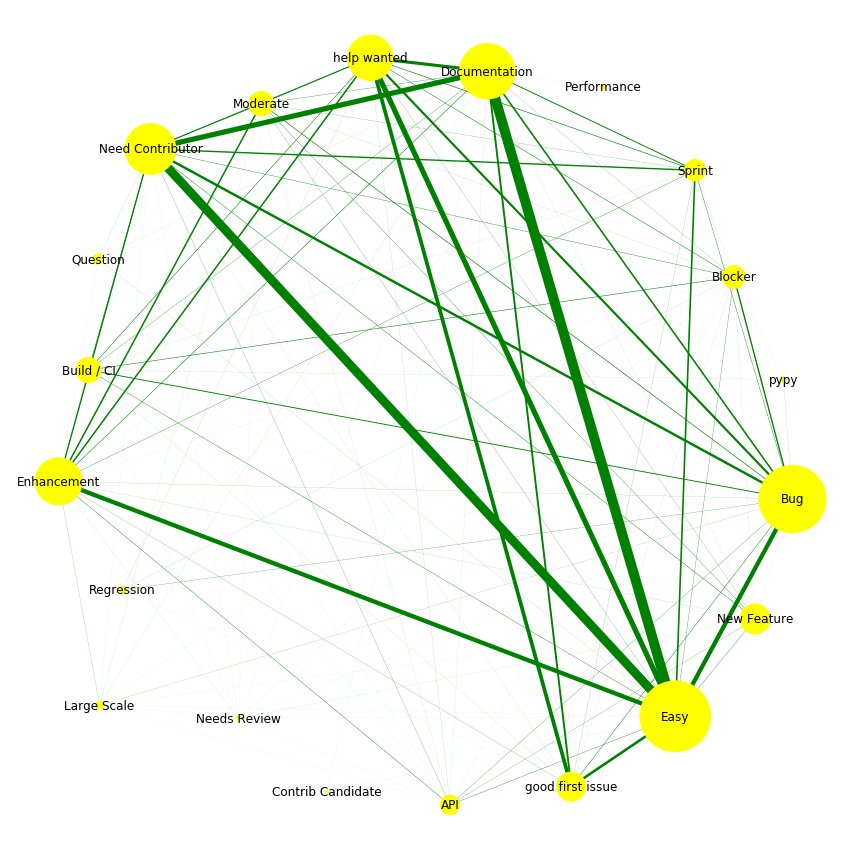

In [9]:
plt.figure(figsize=(12, 12))
G = nx.Graph()
node_list = list(labels['name'])
for node in node_list:
    G.add_node(node)
# pos = nx.circular_layout(G)
pos = nx.spring_layout(G)
node_size = issues_cnt["issue_cnt"]
nx.draw_networkx_nodes(G, pos, node_color='yellow', node_size=node_size / max(node_size) * 5000)
edge_list = list(edge_dict.keys())
edge_width = list(edge_dict.values())
nx.draw_networkx_edges(G, pos, edge_color='green', edgelist=edge_list, width=np.array(edge_width) / max(edge_width) * 10)
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.tight_layout()